In [1]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = './data/SMOTE_data.csv'
df = pd.read_csv(file_path)

In [2]:
df.shape

(7964190, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964190 entries, 0 to 7964189
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   dst2src_first_seen_ms      float64
 1   dst2src_last_seen_ms       float64
 2   dst2src_max_piat_ms        float64
 3   bidirectional_syn_packets  float64
 4   src2dst_syn_packets        float64
 5   application_name           float64
 6   application_category_name  float64
 7   application_is_guessed     float64
 8   application_confidence     float64
 9   label_mul                  int64  
dtypes: float64(9), int64(1)
memory usage: 607.6 MB


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual DataFrame)
data = {
    'dst2src_first_seen_ms': np.random.rand(100),
    'dst2src_last_seen_ms': np.random.rand(100),
    'dst2src_max_piat_ms': np.random.rand(100),
    'bidirectional_syn_packets': np.random.rand(100),
    'src2dst_syn_packets': np.random.rand(100),
    'application_is_guessed': np.random.randint(0, 2, 100),
    'application_confidence': np.random.rand(100),
    'label_mul': np.random.randint(0, 15, 100)
}

df = pd.DataFrame(data)

# Create binary labels
df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)

# Prepare features and labels
features = df.drop(columns=['label_mul', 'binary_label', 'application_is_guessed', 'application_confidence'])
labels = df['binary_label'].values





In [6]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [7]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [9]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label_mul'])
    y = to_categorical(y_encoded)
    X = df.drop(['label_mul'], axis=1).values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    timesteps, features = 1, X_scaled.shape[1] // 1
    X_reshaped = X_scaled.reshape(-1, timesteps, features)
    return X_reshaped, y, timesteps, features


In [10]:
def distribute_data_dirichlet(X, y, num_clients, alpha=0.01):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    num_classes = len(np.unique(y_labels))
    class_indices = [np.where(y_labels == i)[0] for i in range(num_classes)]

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        np.random.shuffle(class_indices[c])
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = proportions / proportions.sum()  # Normalize proportions

        split_points = (np.cumsum(proportions) * len(class_indices[c])).astype(int)
        split_points[-1] = len(class_indices[c])  # Ensure last point matches length
        splits = np.split(class_indices[c], split_points[:-1])

        for i in range(num_clients):
            client_indices[i].extend(splits[i])

    clients_data = [(X[client_idx], y[client_idx]) for client_idx in client_indices]
    return clients_data


In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_label_distribution(clients_data, task_name,alpha,exclude_label=6 ):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task aplha ={alpha}')

    # Create a color map (using a colormap like 'tab10', 'tab20', etc.)
    cmap = plt.get_cmap('tab10')  # tab10 has 10 different colors
    colors = [cmap(i) for i in range(10)]  # Adjust according to number of labels you have

    for i, (X_client, y_client) in enumerate(clients_data):
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        labels = labels[labels != exclude_label]

        unique, counts = np.unique(labels, return_counts=True)

        # Assign a color for each unique label
        label_colors = [colors[label % len(colors)] for label in unique]

        axes[i].bar(unique, counts, color=label_colors)
        axes[i].set_title(f'Client {i+1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    plt.savefig('attack_distributiona.png', dpi=600, bbox_inches='tight')
    plt.show()


In [12]:
num_clients = 5
num_rounds = 10
task_name = 'Non-IID'
alpha = 1000

In [13]:
X, y, timesteps, features = load_and_preprocess_data(file_path)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
def apply_smote(X, y):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    smote = SMOTE()
    try:
        X_reshaped = X.reshape(X.shape[0], -1)
        X_resampled, y_resampled_labels = smote.fit_resample(X_reshaped, y_labels)
        y_resampled = to_categorical(y_resampled_labels, num_classes=y.shape[1])
        X_resampled_reshaped = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled_reshaped, y_resampled
    except Exception as e:
        print(f"SMOTE could not be applied: {e}")
        return X, y


In [ ]:
X_smote, y_smote = apply_smote(x_train, y_train)

In [26]:
# Distribute data using Dirichlet distribution
clients_data = distribute_data_dirichlet(X_smote, y_smote, num_clients, alpha)

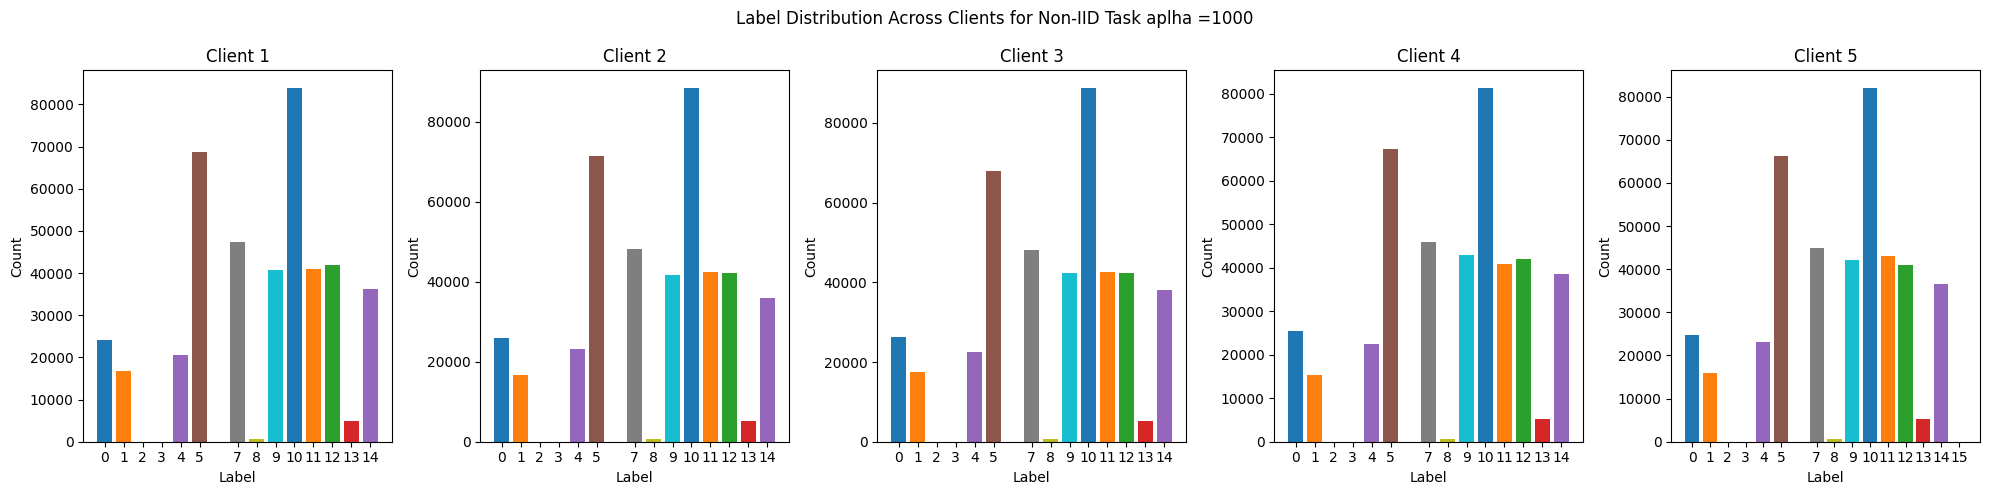

In [27]:
# Plot label distribution
plot_label_distribution(clients_data, task_name ,alpha)
